-----
## **Mount gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = '/content/drive/My Drive/CS489 Team 3 Project/Irfan\'s code'

---
## **Import Libraries**

In [ ]:
import os

# Regular visualization libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Keras and tensorflow
import tensorflow as tf
import tensorflow_hub as hub

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import backend
from tensorflow.keras import optimizers

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

---
## **Load the data**

The data is obtained from
https://www.kaggle.com/snapcrack/all-the-news

we used the half of combination of the three datasets provided by the kaggle link above.

In [ ]:
csv = [root + '/articles1.csv', root + '/articles2.csv', root + '/articles3.csv']
df = pd.concat(map(pd.read_csv, csv), ignore_index=True) #concat all the three datasets from the kaggle
df = df[df.index % 2 == 0] #only take half of the data
df

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
6,6,17289,Taiwan’s President Accuses China of Renewed In...,New York Times,Javier C. Hernández,2017-01-02,2017.0,1.0,NaN,BEIJING — President Tsai of Taiwan sharpl...
8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ..."
...,...,...,...,...,...,...,...,...,...,...
142560,146023,218073,What U.S. Muslims fear from Trump,Washington Post,Naureen Shah,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Naureen Shah is director of security and hu...
142562,146025,218075,British leader Theresa May breaks with John Ke...,Washington Post,Michael Birnbaum,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,BRUSSELS — British Prime Minister Theresa...
142564,146027,218077,A Mormon Tabernacle Choir member is resigning ...,Washington Post,Sarah Larimer,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,"The decision was not an easy one, wrote J..."
142566,146029,218079,Plane carrying six people returning from a Cav...,Washington Post,Sarah Larimer,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Crews on Friday continued to search L...


---
##**Manually label the data according to https://mediabiasfactcheck.com/**

*   **New York Times**: Left-center<br>
*   **Breitbart**: Extreme right <br>
*   **CNN**: Left<br>
*   **Business Insider**: Left-center <br>
*   **Atlantic**: Left-center <br>
*   **Fox News**: Right<br>
*   **Talking Points Memo**: Left <br>
*   **Buzzfeed News**: Left-center <br>
*   **National Review**: Right <br>
*   **New York Post**: Right-center <br>
*   **Guardian**: Left-center<br>
*   **NPR**: Left-center<br>
*   **Reuters**: Right<br>
*   **Vox**: Left<br>
*   **Washington Post**: Left-center<br>


###**The label is as follows:**
*   Left: 1
*   Left-center: 2
*   Right-center: 3
*   Right: 4





###Collect the news text into one list

In [ ]:
pub_list = ['New York Times', 'Breitbart', 'CNN', 'Business Insider', 'Atlantic', 'Fox News',
            'Talking Points Memo', 'Buzzfeed News', 'National Review', 'New York Post',
            'Guardian', 'NPR', 'Reuters', 'Vox', 'Washington Post']

pub_dict = {}

for pub in pub_list:
  pub_dict[pub] = df[df['publication'] == pub]

n_s = []

for pub in pub_dict:
  n_s += list(pub_dict[pub].iloc[:,9].values)

print(len(n_s))

71285


###remove the publication word from the sentence

In [ ]:
for word in n_s:
  for pub in pub_dict:
    word.replace(pub,'')

###Manually label the data as mentioned above

In [ ]:
#Bias classifier:
#    Left: 1
#    Left-center: 2
#    Right-center: 3
#    Right: 4

classes_Bias = np.asarray([2 for i in range(len(pub_dict['New York Times']))] + 
                          [4 for i in range(len(pub_dict['Breitbart']))] + 
                          [1 for i in range(len(pub_dict['CNN']))] + 
                          [2 for i in range(len(pub_dict['Business Insider']))] +
                          [2 for i in range(len(pub_dict['Atlantic']))] + 
                          [4 for i in range(len(pub_dict['Fox News']))] + 
                          [1 for i in range(len(pub_dict['Talking Points Memo']))] + 
                          [2 for i in range(len(pub_dict['Buzzfeed News']))] + 
                          [4 for i in range(len(pub_dict['National Review']))] + 
                          [3 for i in range(len(pub_dict['New York Post']))] + 
                          [2 for i in range(len(pub_dict['Guardian']))] + 
                          [2 for i in range(len(pub_dict['NPR']))] + 
                          [4 for i in range(len(pub_dict['Reuters']))] + 
                          [1 for i in range(len(pub_dict['Vox']))] + 
                          [2 for i in range(len(pub_dict['Washington Post']))])


---
##**Encode the news text into vector**

we use universal text encoder from https://tfhub.dev/google/universal-sentence-encoder/3

In [ ]:
# Load the encoder:
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

# Initialize session:
session = tf.Session(graph=g)
session.run(init_op)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Define the similarity matrix

In [ ]:
# Calculate the similarity matrix, since the conversion takes a lot of time, we use the precalculated array below.
def similarity_matrix(merge_list):
    emb_all = np.zeros([len(merge_list),512])
    for i in range(len(merge_list)):
        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})
        emb_all[i,:] = i_emb
    return emb_all

###Save or load the similarity matrix

NOTE! if you do not use the preprocess array, you can uncomment the cell below and embed the text by yourself

In [ ]:
# e_All_four = similarity_matrix(n_s)

#save the array for later usage
# np.save(root + '/e_All_four_0_2.npy', e_All_four)

In [ ]:
e_All_four = np.load(root + '/e_All_four_0_2.npy')

---
##**Define the training model**

In [ ]:
#Optimizer
optim = optimizers.Adam(learning_rate=0.00015) 

# create the NN layers
news_DNN = Sequential()
news_DNN.add(Dense(100, input_dim=512, activation = LeakyReLU() ,kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))
news_DNN.add(Dense(100, activation = LeakyReLU() ,kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))

# Since our output is either left, left-center, right-center, right, we have four nodes at the output layer
news_DNN.add(Dense(4,activation='softmax'))

# Compile the model:
news_DNN.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['acc'])

In [ ]:
# The summary of the model
news_DNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               51300     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 404       
                                                                 
Total params: 61,804
Trainable params: 61,804
Non-trainable params: 0
_________________________________________________________________


###Split and scale the data

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33) 
scaler = StandardScaler()
for t, te in sss.split(e_All_four, classes_Bias):
    X_train, X_test = scaler.fit_transform(e_All_four)[t], scaler.fit_transform(e_All_four)[te]

    y_train, y_test = classes_Bias[t]-1,classes_Bias[te]-1

### Fit the network

In [ ]:
m_h = news_DNN.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Train on 47760 samples, validate on 23525 samples
Epoch 1/400
47424/47760 [============================>.] - ETA: 0s - loss: 7.4752 - acc: 0.4930

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


47760/47760 [==============================] - 4s 92us/sample - loss: 7.4322 - acc: 0.4935 - val_loss: 1.3650 - val_acc: 0.5374
Epoch 2/400
47760/47760 [==============================] - 4s 91us/sample - loss: 1.2006 - acc: 0.5400 - val_loss: 1.1465 - val_acc: 0.5556
Epoch 3/400
47760/47760 [==============================] - 4s 89us/sample - loss: 1.1453 - acc: 0.5482 - val_loss: 1.1226 - val_acc: 0.5638
Epoch 4/400
47760/47760 [==============================] - 4s 89us/sample - loss: 1.1310 - acc: 0.5551 - val_loss: 1.1107 - val_acc: 0.5719
Epoch 5/400
47760/47760 [==============================] - 4s 89us/sample - loss: 1.1200 - acc: 0.5593 - val_loss: 1.1016 - val_acc: 0.5692
Epoch 6/400
47760/47760 [==============================] - 4s 90us/sample - loss: 1.1128 - acc: 0.5610 - val_loss: 1.0962 - val_acc: 0.5665
Epoch 7/400
47760/47760 [==============================] - 4s 88us/sample - loss: 1.1083 - acc: 0.5607 - val_loss: 1.0894 - val_acc: 0.5781
Epoch 8/400
47760/47760 [=======

---
##**Result visualization**

###Loss

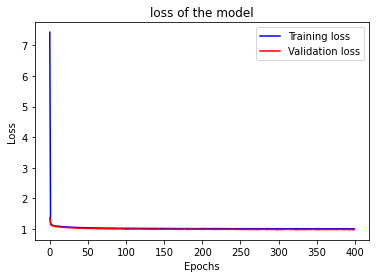

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(m_h, "loss of the model")

###Accuracy

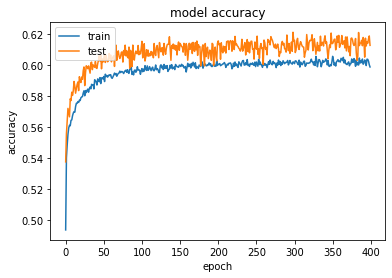

In [ ]:
def visualize_acc(history):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

visualize_acc(m_h)

###Confusion matrix

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


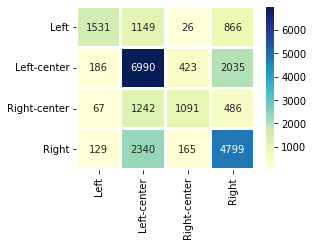

In [ ]:
# Plot confusion matrix:
y_pred = news_DNN.predict(X_test)
classes_y= np.argmax(y_pred,axis=1)


plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test,classes_y),annot=True,linewidths=2, cmap="YlGnBu",fmt="g", xticklabels=['Left','Left-center', 'Right-center', 'Right'], yticklabels=['Left','Left-center', 'Right-center', 'Right']) # Or change labels to ['outlet1','outlet2','outlet3','outlet4'] for outlet classifier
plt.autoscale()
plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight") # edit file title here

---
##**Make a prediction**

###Polarization Score Function

The mechanism is as follows:
<br>
<br>
Since we have four possible outputs (left, left-center, right, right-center), we will determine the score based on the model confident level of the predicted output.

**Left-center and Right center**


```
score = 50  * model's confident level of the predicted output - 12.5 * (1 - model's confident level of the predicted output)
```


**Left and Right**


```
score = 50 + (50  * model's confident level of the predicted output - 12.5 * (1 - model's confident level of the predicted output))
```





In [ ]:
def polarization_score(pred_list, cls):
  if cls == 0 or cls == 3:
    return int(50 + 50 * pred_list[cls] - 12.5 * (1 - pred_list[cls]))
  else:
    return int(50 * pred_list[cls]- 12.5 * (1 - pred_list[cls]))

### Make Prediction Function

In [ ]:
def make_pred(news_text):
  sim_matrix = session.run(embedded_text, feed_dict={text_input: [news_text]})
  combine = np.vstack([e_All_four, sim_matrix])
  sca = scaler.fit_transform(combine)[-1]
  sca = np.array([sca])
  # sca = sca.reshape(sca.shape[0], 1, sca.shape[1])
  pred = news_DNN.predict(sca)
  classes_y= np.argmax(pred,axis=1)

# Make the prediction based on the output of the model
  if classes_y[0] == 0:
    return 'Left', polarization_score(pred[0], classes_y)
  elif  classes_y[0] == 1:
    return 'Left-center', polarization_score(pred[0], classes_y)
  elif  classes_y[0] == 2:
    return 'right-center', polarization_score(pred[0], classes_y)
  else:
    return 'right', polarization_score(pred[0], classes_y)

###Prediction example

In [ ]:
text = 'Former Vice President Joe Biden (D) defeated Trump in the 2020 presidential election on November 3, 2020. Biden received 306 electoral votes, while Trump received 232. Trump won the 2016 presidential election against Hillary Clinton (D), receiving 304 electoral votes. Key policy initiatives during Trump\'s first term included the United States withdrawing from the Iran nuclear deal, the passage of the Tax Cuts and Jobs Act of 2017 and First Step Act in 2018, reducing the size of the ISIS caliphate, and establishing the Space Force as an independent military branch.[1][2] Trump made more than 200 federal judicial appointments, including three U.S. Supreme Court justices. During his presidency, Trump issued nine vetoes. To read more about these vetoes, click here. On December 18, 2019, Trump became the third president in U.S. history to be impeached by the U.S. House.[3] The U.S. Senate acquitted Trump on both charges of abuse of power and obstruction of Congress on February 5, 2020.[4] Trump was impeached a second time on January 13, 2021, for incitement of insurrection. The Senate acquitted Trump on February 13, 2021.'

make_pred(text)

('Left-center', 25)

---
##**Save the trained model**

In [ ]:
news_DNN.save(root + '/news_DNN_four')